In [1]:

from sklearn.cluster import KMeans
from sentence_transformers import SentenceTransformer
from sklearn.feature_extraction.text import CountVectorizer
import pandas as pd
from bertopic import BERTopic
from bertopic.representation import KeyBERTInspired
from bertopic.vectorizers import ClassTfidfTransformer
import numpy as np
import math
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA


/Users/jessicaluo/Desktop/scrap/text_processes/lib/python3.12/site-packages/sentence_transformers/cross_encoder/CrossEncoder.py:11: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm, trange


# open csv

In [2]:
# open preprocessed data
df = pd.read_csv('../data/processed_reviews.csv')
# select subcategory to analyze
subcategory = 'BODY CARE BODY LOTION'
# subcategory = 'SPRAY CLEANERS BLEACH CLEANERS'
label = "lotion"
df = df[df['subcategory'] == subcategory]
print(df.shape)
df.head()

(20281, 10)


,brand,product_title,proxy_date,retailer,category,subcategory,review_text,star_rating,topic,brand_type
210565,Palmer's,Palmer's Cocoa Butter Formula Daily Skin Thera...,2024-07-01,CVS,PERSONAL CARE,BODY CARE BODY LOTION,i have use this lotion for year and love it ve...,5.0,Moisturizer preference and usage habits,Competitor
210757,EOS,eos Shea Better Moisture Body Lotion - Vanilla...,2024-07-01,Target,PERSONAL CARE,BODY CARE BODY LOTION,ive be look for a new body lotion from a compa...,3.0,Positive reviews for a makeup remover (undeter...,Competitor
210829,Eucerin,Eucerin Intensive Repair Very Dry Skin Lotion ...,2024-07-01,Amazon,PERSONAL CARE,BODY CARE BODY LOTION,this lotion be a must have if you have dry ski...,5.0,Positive reviews for a makeup remover (undeter...,Competitor
210925,Medix 5.5,Medix 5.5 Retinol Body Lotion Firming Moisturi...,2024-07-01,Amazon,PERSONAL CARE,BODY CARE BODY LOTION,no retinol list on ingredient list,1.0,Positive reviews for a makeup remover (undeter...,Competitor
211032,Medix 5.5,Medix 5.5 Retinol Body Lotion Firming Moisturi...,2024-07-01,Amazon,PERSONAL CARE,BODY CARE BODY LOTION,i love this lotion lovely scent it have bright...,5.0,Positive reviews for a makeup remover (undeter...,Competitor


In [3]:
# group reviews by subcategory and make dictrionary with rating: review_text
grouped = df.groupby('star_rating').apply(lambda x: x['review_text'].tolist()).to_dict()

/var/folders/x2/lsyflj4j07jc1sb3w3hfgmjc0000gn/T/ipykernel_89236/719716116.py:2: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  grouped = df.groupby('star_rating').apply(lambda x: x['review_text'].tolist()).to_dict()


In [4]:
def get_number_topics(num_reviews):
    if num_reviews > 50000:
        return 20
    if num_reviews > 25000:
        return 15
    if num_reviews > 10000:
        return 10
    if num_reviews > 5000:
        return 8
    if num_reviews > 1000:
        return 6
    if num_reviews > 500:
        return 5
    if num_reviews > 100:
        return 4
    if num_reviews > 50:
        return 3
    if num_reviews > 10:
        return 2
    return 1
total_topics = get_number_topics(df.shape[0])
total_topics

10

In [5]:
def calculate_num_topics_star_rating(total_topics, star_rating, min_topics=1):
    # logarithmic weighting (smooth it out)
    weight = math.log(6 - star_rating + 1)  # Adding 1 to avoid log(0)


    # normalize weight to ensure sum of the topics is not greater than total_topics
    total_weight = sum(math.log(6 - r + 1) for r in range(1, 6))
    normalized_weight = weight / total_weight


    # number of topics for the group based on normalized weight
    num_topics = max(min_topics, math.ceil(normalized_weight * total_topics))


    return num_topics

total = df.shape[0]
print("number of reviews", total)
# cur_num_topics = 0
# for i in range(1, 6):
#     print(f'num topics for rating {i} with {len(grouped[i])} reviews:')
#     print(calculate_num_topics(len(grouped[i]), total, total_topics, i))
#     cur_num_topics += calculate_num_topics(len(grouped[i]), total, total_topics, i)
# print(cur_num_topics)


number of reviews 20281


## calculated number of topics per rating

In [6]:
num_topics_per_rating = {}
for i in range(1, 6):
    num_topics_per_rating[i] = calculate_num_topics_star_rating(total_topics, i)
    print(f'Rating {i} with {len(grouped[i])} reviews: {num_topics_per_rating[i]} topics')

Rating 1 with 1525 reviews: 3 topics
Rating 2 with 666 reviews: 3 topics
Rating 3 with 1059 reviews: 3 topics
Rating 4 with 2597 reviews: 2 topics
Rating 5 with 14434 reviews: 2 topics


# BERTopic models

In [7]:
def create_topic_model(text, num_topics):
    # Step 1 - Extract embeddings
    embedding_model = SentenceTransformer("all-MiniLM-L6-v2")

    # Step 2 - Reduce dimensionality
    pca_model = PCA(n_components=10)

    # Step 3 - Cluster reduced embeddings
    cluster_model = KMeans(n_clusters=num_topics)

    # Step 4 - Tokenize topics
    vectorizer_model = CountVectorizer(stop_words="english")

    # Step 5 - Create topic representation
    ctfidf_model = ClassTfidfTransformer()

    # Step 6 - (Optional) Fine-tune topic representations with 
    # a `bertopic.representation` model
    representation_model = KeyBERTInspired()

    topic_model = BERTopic(
        embedding_model=embedding_model,          # Step 1 - Extract embeddings
        umap_model=pca_model,                    # Step 2 - Reduce dimensionality
        hdbscan_model=cluster_model,              # Step 3 - Cluster reduced embeddings
        vectorizer_model=vectorizer_model,        # Step 4 - Tokenize topics
        ctfidf_model=ctfidf_model                # Step 5 - Extract topic words
       # representation_model=representation_model # Step 6 - (Optional) Fine-tune topic representations
    )

    # Fit BERTopic model
    topic_model.fit_transform(text)
    return topic_model

In [9]:
import time
models = {}
total_time = 0
for rating, reviews in grouped.items():
    print(f'Rating {rating} with {len(reviews)} reviews')
    num_topics = num_topics_per_rating[rating]
    start = time.time()
    models[rating] = create_topic_model(reviews, num_topics)
    time_taken = time.time() - start
    print(f'Time taken: {time_taken} seconds')
    total_time += time_taken
    print('\n')

Rating 1.0 with 1525 reviews
Time taken: 32.14450788497925 seconds


Rating 2.0 with 666 reviews
Time taken: 27.866179943084717 seconds


Rating 3.0 with 1059 reviews
Time taken: 41.31513786315918 seconds


Rating 4.0 with 2597 reviews
Time taken: 81.02563691139221 seconds


Rating 5.0 with 14434 reviews
Time taken: 187.7036018371582 seconds




took 25.7 s to create models with pca components = 5

## number of topics generated per rating

In [10]:
for rating, model in models.items():
    print(f'Rating {rating} with {len(model.get_topic_freq())} topics')
    print(model.get_topic_freq())
    print('\n')

Rating 1.0 with 3 topics
   Topic  Count
0      0    795
1      1    416
2      2    314


Rating 2.0 with 3 topics
   Topic  Count
1      0    295
0      1    241
2      2    130


Rating 3.0 with 3 topics
   Topic  Count
1      0    488
0      1    365
2      2    206


Rating 4.0 with 2 topics
   Topic  Count
1      0   1602
0      1    995


Rating 5.0 with 2 topics
   Topic  Count
0      0   9547
1      1   4887




## create dataframe of topics

In [11]:
df_topics = pd.DataFrame(columns=['star_rating', 'topic_number', 'count', 'topic_words'])
for rating, model in models.items():
    res = model.get_topic_info()
    for index, row in res.iterrows():
        new_row = pd.DataFrame({
            'star_rating': [rating],
            'topic_number': [row['Topic']],
            'count': [row['Count']],
            'topic_words': [row['Representation']]
        })
        df_topics = pd.concat([df_topics, new_row], ignore_index=True)

df_topics

,star_rating,topic_number,count,topic_words
0,1.0,0,795,"[use, skin, formula, lotion, new, product, cha..."
1,1.0,1,416,"[smell, scent, like, lotion, use, change, new,..."
2,1.0,2,314,"[pump, product, order, open, bottle, receive, ..."
3,2.0,0,295,"[skin, lotion, use, dry, product, feel, like, ..."
4,2.0,1,241,"[smell, like, scent, lotion, just, good, vanil..."
5,2.0,2,130,"[pump, product, use, work, bottle, change, lot..."
6,3.0,0,488,"[skin, lotion, use, dry, product, good, like, ..."
7,3.0,1,365,"[smell, lotion, scent, like, skin, use, feel, ..."
8,3.0,2,206,"[product, pump, bottle, work, lotion, like, us..."
9,4.0,0,1602,"[skin, lotion, use, dry, product, feel, great,..."


## label reviews with topic

In [12]:
# label reviews in df with topics
labeled_reviews = pd.DataFrame()
for rating, model in models.items():
    labeled_reviews = pd.concat([labeled_reviews, model.get_document_info(grouped[rating])], ignore_index=True)
labeled_reviews

,Document,Topic,Name,Representation,Representative_Docs,Top_n_words,Representative_document
0,no retinol list on ingredient list,0,0_use_skin_formula_lotion,"[use, skin, formula, lotion, new, product, cha...",[ive be use this product for over 20 year it h...,use - skin - formula - lotion - new - product ...,False
1,same as everyone else… the change theyve make ...,0,0_use_skin_formula_lotion,"[use, skin, formula, lotion, new, product, cha...",[ive be use this product for over 20 year it h...,use - skin - formula - lotion - new - product ...,False
2,if youre look for something that smell good th...,1,1_smell_scent_like_lotion,"[smell, scent, like, lotion, use, change, new,...",[it smell nice in the bottle but once i put it...,smell - scent - like - lotion - use - change -...,False
3,use this on my arm and leg have a strange text...,0,0_use_skin_formula_lotion,"[use, skin, formula, lotion, new, product, cha...",[ive be use this product for over 20 year it h...,use - skin - formula - lotion - new - product ...,False
4,i didnt get this because my shopper decide the...,2,2_pump_product_order_open,"[pump, product, order, open, bottle, receive, ...",[the pump doesnt work on the last two bottle i...,pump - product - order - open - bottle - recei...,False
...,...,...,...,...,...,...,...
20276,i feel this be one of the best lotion out ther...,0,0_skin_lotion_use_dry,"[skin, lotion, use, dry, product, love, feel, ...",[aveeno daily moisturize lotion be my go to lo...,skin - lotion - use - dry - product - love - f...,False
20277,love this lotion use it on a daily basis and i...,1,1_smell_love_scent_good,"[smell, love, scent, good, lotion, like, great...",[love the smell and it feel so smooth on my sk...,smell - love - scent - good - lotion - like - ...,False
20278,this lotion be one of the best lotion i have e...,1,1_smell_love_scent_good,"[smell, love, scent, good, lotion, like, great...",[love the smell and it feel so smooth on my sk...,smell - love - scent - good - lotion - like - ...,False
20279,i be in love with this lotion it make my skin ...,0,0_skin_lotion_use_dry,"[skin, lotion, use, dry, product, love, feel, ...",[aveeno daily moisturize lotion be my go to lo...,skin - lotion - use - dry - product - love - f...,False


## distribution of topics for each rating

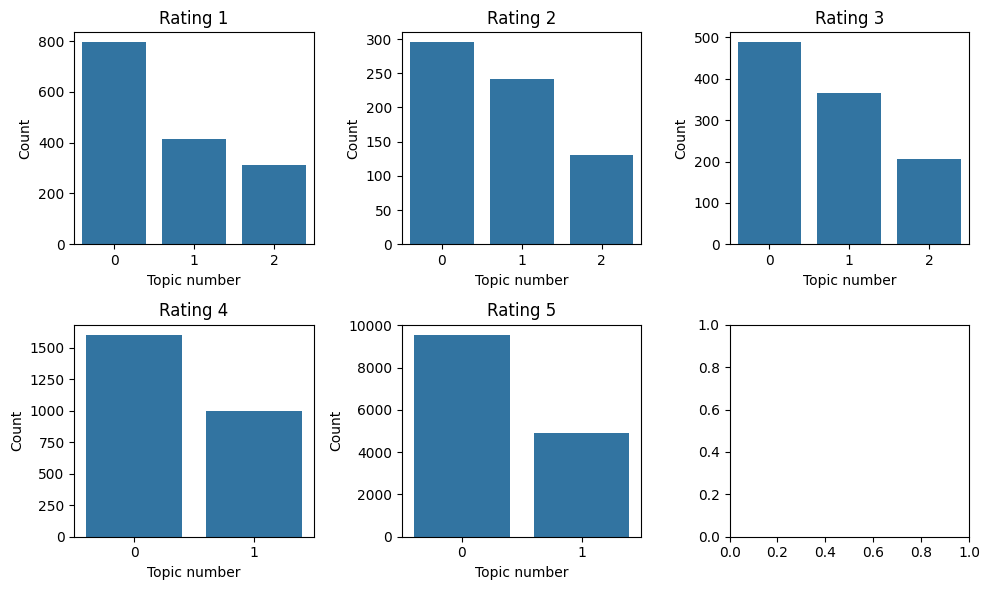

In [13]:
# visualize distribution of topics, one plot per rating arranged in grid with 2 rows and 3 columns
import seaborn as sns

# create grid of plots
fig, axs = plt.subplots(2, 3, figsize=(10, 6))

# iterate over ratings and plot distribution of topics using count column
for i, rating in enumerate(range(1, 6)):
    ax = axs[i // 3, i % 3]
    sns.barplot(x='topic_number', y='count', data=df_topics[df_topics['star_rating'] == rating], ax=ax)
    ax.set_title(f'Rating {rating}')
    ax.set_xlabel('Topic number')
    ax.set_ylabel('Count')

# Display all subplots together
plt.tight_layout()
plt.show()

# generate phrases for topics

In [14]:
import os
from groq import Groq 

# Initialize the client
client = Groq(
    api_key=os.environ.get("GROQ_API_KEY"),
)

# Define the system message
system_message = """
Generate a concise and coherent phrase that summarizes topics based on provided keywords
and associated review ratings. The keywords are ordered by relevance from the most to the least.

Ensure that each phrase accurately reflects the sentiment implied by the rating and highlights key aspects of the topic. 
For example, a rating of 1 should convey dissatisfaction or issues, while a rating of 5 should express satisfaction or positive feedback. 
Omit pronouns and conjunctions to keep the phrase succinct.

For reviews with low ratings (1-2) or with negative keywords, focus on problematic aspects such as defects, damages, or poor quality and 
be as detailed as possible.

Output only the phrase without additional commentary.

Example:

Input: "leak box, return, item, bottle leak, arrive damage, box, arrive, damage leak, damage, leak" Rating: 1
Output: "Leaking or damaged items and boxes upon delivery"
"""

def process_input(top_words, rating):
    user_message = f'Input: "{top_words}" rating: {rating}'
    response = client.chat.completions.create(
        messages=[
            {
                "role": "system",
                "content": system_message
            },
            {
                "role": "user",
                "content": user_message
            }
        ],
        model="llama3-8b-8192",
    )
    generated_phrase = response.choices[0].message.content
    return generated_phrase

# generate phrases for each topic in df_topics and add generated phrase to new column 'phrase'
df_topics['phrase'] = df_topics.apply(lambda x: process_input(x['topic_words'], x['star_rating']), axis=1)
df_topics

,star_rating,topic_number,count,topic_words,phrase
0,1.0,0,795,"[use, skin, formula, lotion, new, product, cha...",Poor lotion formula leads to skin reaction
1,1.0,1,416,"[smell, scent, like, lotion, use, change, new,...","""Unpleasant smell, ineffective lotion formula."""
2,1.0,2,314,"[pump, product, order, open, bottle, receive, ...","""Failed to open or receive faulty pumps and pr..."
3,2.0,0,295,"[skin, lotion, use, dry, product, feel, like, ...",Dry skin after using lotion
4,2.0,1,241,"[smell, like, scent, lotion, just, good, vanil...","""Vanilla-scented lotion with a strong smell"""
5,2.0,2,130,"[pump, product, use, work, bottle, change, lot...","""Pump and product issues with lotion despite g..."
6,3.0,0,488,"[skin, lotion, use, dry, product, good, like, ...",Moisturized skin with decent product
7,3.0,1,365,"[smell, lotion, scent, like, skin, use, feel, ...",Good fragrance feels on skin
8,3.0,2,206,"[product, pump, bottle, work, lotion, like, us...","""Functional lotion pump in a bottle, usable pr..."
9,4.0,0,1602,"[skin, lotion, use, dry, product, feel, great,...","""Moisturizing skin feel great, lotion use good"""


In [15]:
# merge star_rating from df with labeled_reviews, drop review_text column
labeled_reviews = labeled_reviews.merge(df[['review_text', 'star_rating']], left_on='Document', right_on='review_text', how='left').drop(columns=['review_text'])
labeled_reviews

,Document,Topic,Name,Representation,Representative_Docs,Top_n_words,Representative_document,star_rating
0,no retinol list on ingredient list,0,0_use_skin_formula_lotion,"[use, skin, formula, lotion, new, product, cha...",[ive be use this product for over 20 year it h...,use - skin - formula - lotion - new - product ...,False,1.0
1,same as everyone else… the change theyve make ...,0,0_use_skin_formula_lotion,"[use, skin, formula, lotion, new, product, cha...",[ive be use this product for over 20 year it h...,use - skin - formula - lotion - new - product ...,False,1.0
2,if youre look for something that smell good th...,1,1_smell_scent_like_lotion,"[smell, scent, like, lotion, use, change, new,...",[it smell nice in the bottle but once i put it...,smell - scent - like - lotion - use - change -...,False,1.0
3,use this on my arm and leg have a strange text...,0,0_use_skin_formula_lotion,"[use, skin, formula, lotion, new, product, cha...",[ive be use this product for over 20 year it h...,use - skin - formula - lotion - new - product ...,False,1.0
4,i didnt get this because my shopper decide the...,2,2_pump_product_order_open,"[pump, product, order, open, bottle, receive, ...",[the pump doesnt work on the last two bottle i...,pump - product - order - open - bottle - recei...,False,1.0
...,...,...,...,...,...,...,...,...
20276,i feel this be one of the best lotion out ther...,0,0_skin_lotion_use_dry,"[skin, lotion, use, dry, product, love, feel, ...",[aveeno daily moisturize lotion be my go to lo...,skin - lotion - use - dry - product - love - f...,False,5.0
20277,love this lotion use it on a daily basis and i...,1,1_smell_love_scent_good,"[smell, love, scent, good, lotion, like, great...",[love the smell and it feel so smooth on my sk...,smell - love - scent - good - lotion - like - ...,False,5.0
20278,this lotion be one of the best lotion i have e...,1,1_smell_love_scent_good,"[smell, love, scent, good, lotion, like, great...",[love the smell and it feel so smooth on my sk...,smell - love - scent - good - lotion - like - ...,False,5.0
20279,i be in love with this lotion it make my skin ...,0,0_skin_lotion_use_dry,"[skin, lotion, use, dry, product, love, feel, ...",[aveeno daily moisturize lotion be my go to lo...,skin - lotion - use - dry - product - love - f...,False,5.0


In [16]:
# merge phrases with labeled_reviews
labeled_reviews = labeled_reviews.merge(df_topics[['star_rating', 'topic_number', 'phrase']], left_on=['Topic', 'star_rating'], right_on=['topic_number', 'star_rating'], how='left').drop(columns=['topic_number'])
labeled_reviews

,Document,Topic,Name,Representation,Representative_Docs,Top_n_words,Representative_document,star_rating,phrase
0,no retinol list on ingredient list,0,0_use_skin_formula_lotion,"[use, skin, formula, lotion, new, product, cha...",[ive be use this product for over 20 year it h...,use - skin - formula - lotion - new - product ...,False,1.0,Poor lotion formula leads to skin reaction
1,same as everyone else… the change theyve make ...,0,0_use_skin_formula_lotion,"[use, skin, formula, lotion, new, product, cha...",[ive be use this product for over 20 year it h...,use - skin - formula - lotion - new - product ...,False,1.0,Poor lotion formula leads to skin reaction
2,if youre look for something that smell good th...,1,1_smell_scent_like_lotion,"[smell, scent, like, lotion, use, change, new,...",[it smell nice in the bottle but once i put it...,smell - scent - like - lotion - use - change -...,False,1.0,"""Unpleasant smell, ineffective lotion formula."""
3,use this on my arm and leg have a strange text...,0,0_use_skin_formula_lotion,"[use, skin, formula, lotion, new, product, cha...",[ive be use this product for over 20 year it h...,use - skin - formula - lotion - new - product ...,False,1.0,Poor lotion formula leads to skin reaction
4,i didnt get this because my shopper decide the...,2,2_pump_product_order_open,"[pump, product, order, open, bottle, receive, ...",[the pump doesnt work on the last two bottle i...,pump - product - order - open - bottle - recei...,False,1.0,"""Failed to open or receive faulty pumps and pr..."
...,...,...,...,...,...,...,...,...,...
20276,i feel this be one of the best lotion out ther...,0,0_skin_lotion_use_dry,"[skin, lotion, use, dry, product, love, feel, ...",[aveeno daily moisturize lotion be my go to lo...,skin - lotion - use - dry - product - love - f...,False,5.0,"""Lotion moisturizes skin, leaving body feeling..."
20277,love this lotion use it on a daily basis and i...,1,1_smell_love_scent_good,"[smell, love, scent, good, lotion, like, great...",[love the smell and it feel so smooth on my sk...,smell - love - scent - good - lotion - like - ...,False,5.0,"""Good scent and feeling skin product loved"""
20278,this lotion be one of the best lotion i have e...,1,1_smell_love_scent_good,"[smell, love, scent, good, lotion, like, great...",[love the smell and it feel so smooth on my sk...,smell - love - scent - good - lotion - like - ...,False,5.0,"""Good scent and feeling skin product loved"""
20279,i be in love with this lotion it make my skin ...,0,0_skin_lotion_use_dry,"[skin, lotion, use, dry, product, love, feel, ...",[aveeno daily moisturize lotion be my go to lo...,skin - lotion - use - dry - product - love - f...,False,5.0,"""Lotion moisturizes skin, leaving body feeling..."


# evaluate quality of generated phrases

In [20]:
# use sentence transformers to get similarity score between reviews and generated phrases
from sentence_transformers import SentenceTransformer
from torch.nn.functional import cosine_similarity

def similarity_scores(model_name, reviews, topics):
    """
    Calculate the similarity scores between reviews and topics using a pre-trained SentenceTransformer model.
    
    model_name: the name of the pre-trained SentenceTransformer model to use
    reviews: a list of review texts
    topics: a list of topic phrases
    
    return: a 2D numpy array of similarity scores
    """
    model = SentenceTransformer(model_name)
    review_embeddings = model.encode(reviews, convert_to_tensor=True)
    phrase_embeddings = model.encode(topics, convert_to_tensor=True)
    similarity_scores = cosine_similarity(review_embeddings, phrase_embeddings).cpu().numpy()
    return similarity_scores

In [21]:
import time

model = 'all-MiniLM-L6-v2'
reviews = labeled_reviews['Document'].tolist()
topics = labeled_reviews['phrase'].tolist()
# run similarity_scores on chunks of reviews 
chunk_size = 1000
n = labeled_reviews.shape[0]
similarity_scores_list = []
for i in range(0, n, chunk_size):
    print(f'Processing reviews {i} to {min(i+chunk_size, n)}')
    start = time.time()
    similarity_scores_list.extend(similarity_scores(model, reviews[i:i+chunk_size], topics[i:i+chunk_size]))
    end = time.time()
    print(f"Time taken: {end - start}")

labeled_reviews['similarity_score'] = similarity_scores_list

Processing reviews 0 to 1000
Time taken: 18.871479034423828
Processing reviews 1000 to 2000
Time taken: 6.556590795516968
Processing reviews 2000 to 3000
Time taken: 4.924525022506714
Processing reviews 3000 to 4000
Time taken: 5.170151233673096
Processing reviews 4000 to 5000
Time taken: 5.071479082107544
Processing reviews 5000 to 6000
Time taken: 6.3947601318359375
Processing reviews 6000 to 7000
Time taken: 6.295557975769043
Processing reviews 7000 to 8000
Time taken: 9.291594982147217
Processing reviews 8000 to 9000
Time taken: 11.078749895095825
Processing reviews 9000 to 10000
Time taken: 5.694620847702026
Processing reviews 10000 to 11000
Time taken: 4.389555215835571
Processing reviews 11000 to 12000
Time taken: 4.010829925537109
Processing reviews 12000 to 13000
Time taken: 4.93250584602356
Processing reviews 13000 to 14000
Time taken: 6.3429930210113525
Processing reviews 14000 to 15000
Time taken: 5.182018041610718
Processing reviews 15000 to 16000
Time taken: 7.30760121345

In [22]:
# print average similarity score for each rating/topic
avg_scores = labeled_reviews.groupby(['star_rating', 'Topic'])['similarity_score'].mean().reset_index()
avg_scores

,star_rating,Topic,similarity_score
0,1.0,0,0.500556
1,1.0,1,0.442260
2,1.0,2,0.200003
3,2.0,0,0.502651
4,2.0,1,0.528639
5,2.0,2,0.308648
6,3.0,0,0.513163
7,3.0,1,0.574115
8,3.0,2,0.266333
9,4.0,0,0.516145


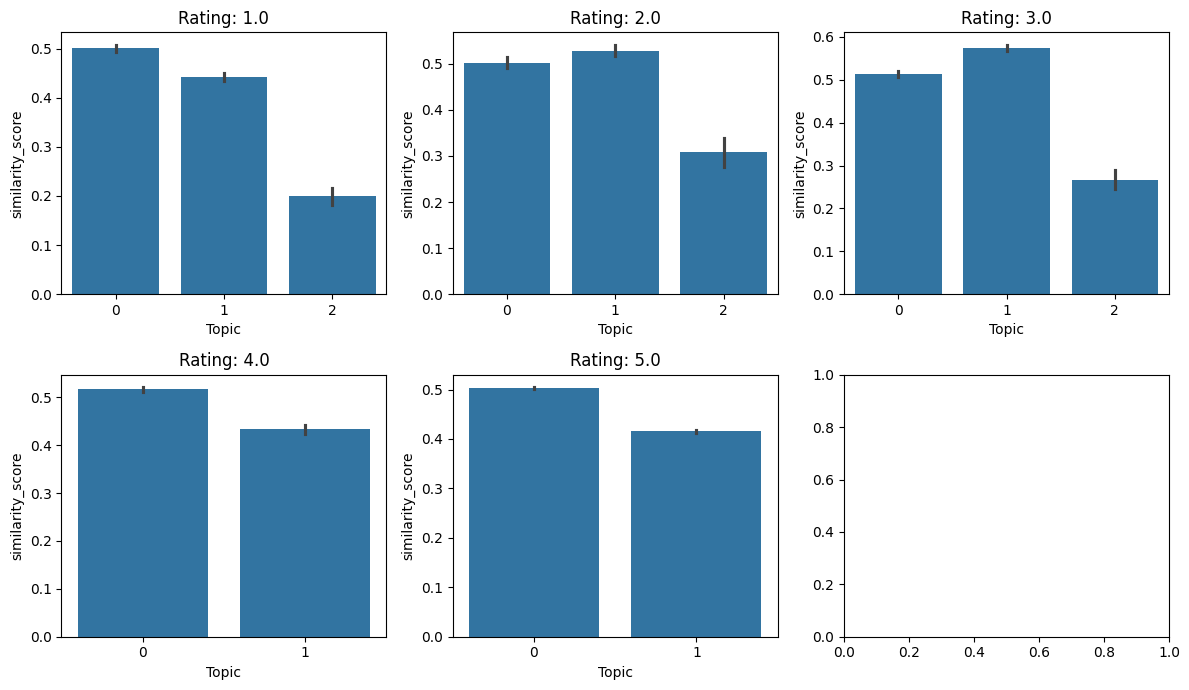

In [23]:
# visualize average similarity scores for each rating/topic
fig, axs = plt.subplots(2, 3, figsize=(12, 7))

for rating in labeled_reviews['star_rating'].unique():
    row = int((rating - 1) // 3)
    col = int((rating - 1) % 3)
    ax = axs[row][col]
    sns.barplot(data=labeled_reviews[labeled_reviews['star_rating'] == rating], x='Topic', y='similarity_score', ax=ax)
    ax.set_title(f"Rating: {rating}")
plt.tight_layout()

In [24]:
# print all topic phrases
for i, row in df_topics.iterrows():
    print(f"{"-" * 100}\nRating: {row['star_rating']} Topic: {row['topic_number']} Phrase: {row['phrase']}\n")
    # print words for the topic
    print(row['topic_words'])

----------------------------------------------------------------------------------------------------
Rating: 1.0 Topic: 0 Phrase: Poor lotion formula leads to skin reaction

['use', 'skin', 'formula', 'lotion', 'new', 'product', 'change', 'year', 'old', 'buy']
----------------------------------------------------------------------------------------------------
Rating: 1.0 Topic: 1 Phrase: "Unpleasant smell, ineffective lotion formula."

['smell', 'scent', 'like', 'lotion', 'use', 'change', 'new', 'product', 'buy', 'formula']
----------------------------------------------------------------------------------------------------
Rating: 1.0 Topic: 2 Phrase: "Failed to open or receive faulty pumps and products"

['pump', 'product', 'order', 'open', 'bottle', 'receive', 'work', 'item', 'return', 'come']
----------------------------------------------------------------------------------------------------
Rating: 2.0 Topic: 0 Phrase: Dry skin after using lotion

['skin', 'lotion', 'use', 'dry', '

In [25]:
# keep Document, phrase, Topic, star_rating, Top_n_words, similarity_score, and standardize column names
to_save = labeled_reviews[['Document', 'phrase', 'Topic', 'star_rating', 'Top_n_words', 'similarity_score']]
to_save.columns = ['review_text', 'topic', 'topic_number', 'star_rating', 'topic_words', 'similarity_score']
to_save.to_csv(f'../outputs/bertopic_{label}_kmeans.csv', index=False)

In [26]:
# average similarity scores for each rating
avg_scores_per_rating = avg_scores.groupby('star_rating')['similarity_score'].mean().reset_index()
avg_scores_per_rating

,star_rating,similarity_score
0,1.0,0.380940
1,2.0,0.446646
2,3.0,0.451204
3,4.0,0.474606
4,5.0,0.459100


In [27]:
overall_avg_score = avg_scores['similarity_score'].mean()
overall_avg_score

np.float32(0.43875232)